In [3]:
import pandas as pd

te = pd.read_csv(
    "Danio_rerio_TE_table.tsv",
    sep="\t"
)

# to drop familes with NA age
# te = te[te["age_Myr"].notna() & (te["age_Myr"] != "NA")]

# clean age to float just in case
te["age_Myr"] = pd.to_numeric(te["age_Myr"], errors="coerce")

# split TE_class into broad type and superfamily
# e.g. "DNA/Harbinger" -> type="DNA", family="Harbinger"
te[["type", "family"]] = te["TE_class"].str.split("/", n=1, expand=True)

# per-chr TE family composition (use bp, not just counts)
te["bp"] = te["length"].astype(int)

per_chr_family = (
    te.groupby(["chrom", "family"])
      .agg({"bp": "sum", "TE_name": "count"})
      .rename(columns={"TE_name": "num_instances"})
      .reset_index()
)

per_chr_family.head()

,chrom,family,bp,num_instances
0,NC_007112.7,5s,243397,792
1,NC_007112.7,Academ,7044,49
2,NC_007112.7,CACTA,3167805,19901
3,NC_007112.7,CR1,62333,216
4,NC_007112.7,Copia,379873,1098


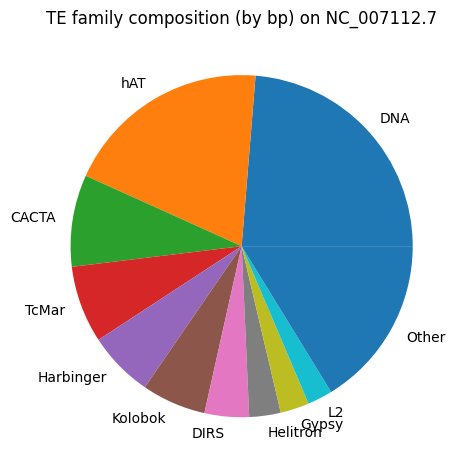

In [8]:
import matplotlib.pyplot as plt

chr_id = "NC_007112.7"
data_chr = per_chr_family[per_chr_family["chrom"] == chr_id]

# Keep only top N families, lump others as "Other"
N = 10
top = data_chr.sort_values("bp", ascending=False).head(N)
others_bp = data_chr["bp"].sum() - top["bp"].sum()

labels = top["family"].tolist()
sizes = top["bp"].tolist()

if others_bp > 0:
    labels.append("Other")
    sizes.append(others_bp)

plt.figure()
plt.pie(sizes, labels=labels)
plt.title(f"TE family composition (by bp) on {chr_id}")
plt.tight_layout()
plt.show()


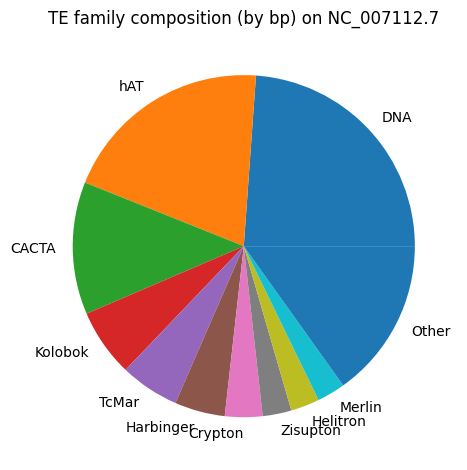

In [9]:
chr_id = "NC_007112.7"
data_chr = per_chr_family[per_chr_family["chrom"] == chr_id]

# Keep only top N families, lump others as "Other"
N = 10
top = data_chr.sort_values("num_instances", ascending=False).head(N)
others_bp = data_chr["num_instances"].sum() - top["num_instances"].sum()

labels = top["family"].tolist()
sizes = top["num_instances"].tolist()

if others_bp > 0:
    labels.append("Other")
    sizes.append(others_bp)

plt.figure()
plt.pie(sizes, labels=labels)
plt.title(f"TE family composition (by bp) on {chr_id}")
plt.tight_layout()
plt.show()


In [12]:
per_chr_type = (
    te.groupby(["chrom", "type"])
      .agg({"bp": "sum", "TE_name": "count"})
      .rename(columns={"TE_name": "num_instances"})
      .reset_index()
)

per_chr_type.head()

,chrom,type,bp,num_instances
0,NC_007112.7,DNA,30395015,141612
1,NC_007112.7,LINE,1899797,6557
2,NC_007112.7,LTR,3841666,9570
3,NC_007112.7,SINE,363620,1280
4,NC_007112.7,Unknown,257579,1333


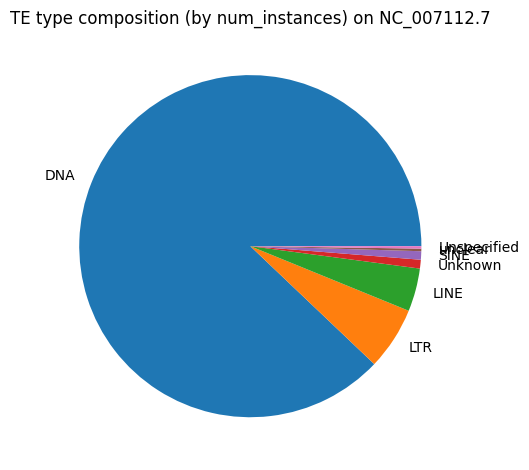

In [14]:
import matplotlib.pyplot as plt

chr_id = "NC_007112.7"
data_chr = per_chr_type[per_chr_type["chrom"] == chr_id]

# Keep only top N families, lump others as "Other"
N = 10
top = data_chr.sort_values("num_instances", ascending=False).head(N)
others_num_instances = data_chr["num_instances"].sum() - top["num_instances"].sum()

labels = top["type"].tolist()
sizes = top["num_instances"].tolist()
if others_num_instances > 0:
    labels.append("Other")
    sizes.append(others_num_instances)

plt.figure()
plt.pie(sizes, labels=labels)
plt.title(f"TE type composition (by num_instances) on {chr_id}")
plt.tight_layout()
plt.show()
